# Applying [Facebook AI's Transformer Model](https://github.com/facebookresearch/esm)

In [ ]:
# AutoML dependencies, may require restarting runtime to allow use of autogluon
!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install autogluon

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
from pathlib import Path

FASTA_DATA = Path("/content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension")

In [4]:
!git clone https://github.com/facebookresearch/esm.git

Cloning into 'esm'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 309 (delta 180), reused 199 (delta 78), pack-reused 0
Receiving objects: 100% (309/309), 6.00 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [5]:
# Add to sys path
import sys
PATH_TO_REPO = "./esm"
sys.path.append(PATH_TO_REPO)

## Setting Up Imports
According to this [notebook](https://colab.research.google.com/github/facebookresearch/esm/blob/master/examples/sup_variant_prediction.ipynb) and HW2b.

In [6]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import esm

In [7]:
import scipy
from autogluon.tabular import TabularPredictor

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)

# From HW2b
def performance_scores(y_true, y_pred_score, y_pred=None): 
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score.loc[:,True], average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

## Generating Embeddings for Negative and Positive Proteins

In [8]:
# Paths for protein FASTAs
POS_FASTA_PATH = FASTA_DATA / "positive_proteins.fasta"
NEG_FASTA_PATH = FASTA_DATA / "negative_proteins.fasta"
# Paths for protein embeddings
POS_EMB_PATH = FASTA_DATA / "pos_reprs"
NEG_EMB_PATH = FASTA_DATA / "neg_reprs"
EMB_LAYER = 34

In [9]:
# Generate positive embeddings
#!python esm/extract.py esm1_t34_670M_UR50S /content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension/positive_proteins.fasta /content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension/pos_reprs --repr_layers 34 --include mean

In [10]:
# Generate negative embeddings
#!python esm/extract.py esm1_t34_670M_UR50S /content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension/negative_proteins.fasta /content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension/neg_reprs --repr_layers 34 --include mean

## Loading embeddings for training

In [11]:
ys = []
Xs = []
prot_ids = []
fasta_params = [
                {
                    'fasta_path': POS_FASTA_PATH,
                    'emb_path': POS_EMB_PATH,
                    'y_val': True
                },
                {
                    'fasta_path': NEG_FASTA_PATH,
                    'emb_path': NEG_EMB_PATH,
                    'y_val': False
                }
]

for parameter in fasta_params:
    for header, _seq in esm.data.read_fasta(parameter['fasta_path']):
        prot_ids.append(header.split()[0][1:])
        ys.append(parameter['y_val'])
        fn = '{}/{}.pt'.format(parameter['emb_path'], header[1:])
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])
Xs = torch.stack(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

233
(233, 1280)


In [12]:
prot_ids_arr = np.array(prot_ids).transpose().reshape((233,1))

In [13]:
ys_arr = np.array(ys).transpose().reshape((233,1))

In [14]:
full_data = pd.DataFrame(np.hstack( (prot_ids_arr, Xs, ys_arr) ))
full_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281
0,NP_001120665.1,-0.22057395,0.18615517,0.45684746,0.10408191,-0.53041434,-0.43731967,0.57258624,-0.22431217,0.11695757,-0.9692971,0.32982147,1.1695734,0.76107985,-1.2184731,0.6318051,0.7703402,-0.5391412,0.01687996,-0.34005314,-0.40403712,-0.4139928,0.5820841,-0.65158546,-0.415874,0.4825549,0.38777593,0.98151714,0.6900816,-0.4430851,-0.08767945,0.5416329,0.24963747,-1.3399305,0.97315395,-0.9563706,1.2849034,-0.07679915,-1.6252421,-1.699049,...,-1.9184895,1.6055951,-0.54004264,-0.22953738,-0.10543016,-0.9312104,-0.7477984,0.286205,0.5353433,0.41363508,-0.06426612,1.0176095,0.2511051,-0.34526926,0.57518333,0.89688677,0.69346434,-0.38505054,-0.38557208,1.310232,0.4234373,-0.5577704,-0.4821987,0.09248934,0.27832025,0.6659539,0.48315188,-2.1956131,0.96766895,-0.75430393,0.40304136,-0.086857215,0.6594585,-0.12961325,0.9957295,1.4758301,1.4888974,-0.06666179,-0.24982595,True
1,YP_009742613.1,-3.1114852,0.09414116,0.4156583,0.22729206,0.33498767,0.9936048,-0.4696841,-0.46670896,0.48954868,-3.7605574,-1.1584069,0.16526432,0.4349719,-2.2860928,-0.39958096,-1.237658,-0.24303368,1.8887388,1.4536105,1.3481232,0.26947862,1.5742811,0.06931676,0.84435666,0.67559534,-1.2015482,2.076504,1.7672447,-1.2512224,-0.8359828,2.345351,-0.68039006,-3.513887,-0.058861107,1.7075484,-0.4496596,-1.2787585,0.31632268,-0.7716943,...,-0.5935226,-0.35610873,1.2271243,1.0039344,0.5337531,-0.42320532,-0.09224061,1.422671,-1.5232943,-1.1356705,0.08698754,2.6771207,0.039096307,0.7296839,0.6862012,-0.14545459,0.31233573,-1.1319882,0.28139788,0.14693998,1.8784721,-1.3640672,0.41507915,1.8447167,-1.015093,-0.8474411,0.53807896,3.059524,0.041957647,-0.15530123,-0.5039473,-1.1163971,-0.8842725,0.21969764,-1.4018204,2.682921,0.65909994,-1.374166,0.38730022,True
2,NP_055935.4,-1.8330696,0.59555787,-0.1714995,2.6139634,0.6814504,1.0345926,1.0690461,-1.2986858,1.3615383,-3.54562,1.4468364,-1.7962416,0.056978945,-4.206652,0.3262889,-2.0456507,-1.9862009,1.0788059,0.89453125,1.050709,-3.7854292,0.7825051,-0.35647815,0.28901005,1.0403692,-1.5290749,3.8530731,1.8645183,0.66817266,-0.70372814,1.1241786,-0.015125384,-5.0198255,0.9350577,-0.10497995,0.46392727,-2.1115997,-0.30353528,-1.1699024,...,-2.9053369,2.8605213,-1.5085341,-0.71128833,-0.0682981,2.1351316,-1.0084573,-0.11713221,1.4444262,-1.146424,-0.3072093,1.0936931,-1.9748528,0.32151482,0.049818717,0.5155335,0.8399605,-0.7206883,-1.875965,-0.15133636,2.4933414,-0.43733904,0.2641232,2.9880197,-2.102766,0.28247386,-1.6126304,0.74059045,-0.61921877,0.5707749,-2.0083,-1.0356369,1.7640718,0.43998387,-0.95514524,1.5472664,1.8745456,-1.5115198,-0.9428531,True
3,NP_001129125.1,-0.7392167,-0.1463649,-0.4953765,-0.25799292,-0.7111692,-0.29839557,0.030671496,0.6381738,0.20182024,0.50054455,0.8420712,-0.19168836,0.046552613,0.39649007,2.303308,-0.11858165,-0.27378243,-0.8427284,0.76950777,-1.015437,0.3575235,0.0025113367,-0.4012772,-1.0393242,-0.006819627,0.18483786,0.38895628,-0.8493349,-0.011715698,0.16693197,0.77027303,1.3252548,0.9442055,1.4091113,-0.019473117,2.0298636,-0.27372703,-0.31788057,-0.22459738,...,-1.0105908,0.4616431,0.030206518,0.073124155,-1.1312356,0.47974804,0.6124574,1.7706358,1.1195549,-1.3433117,-0.076647535,1.1928953,0.98229396,-0.029120237,0.5751302,0.64011335,2.1037712,-0.5985165,0.8982987,0.8545745,-1.0454108,-0.6962902,-0.5690357,-1.7708635,0.73592556,0.25752336,-0.49369973,1.0105219,-0.59974164,0.71197736,0.74558836,0.71689266,1.052321,1.3694965,0.59086597,0.633583,-0.37474334,1.4073533,0.72479165,True
4,YP_009725310.1,-2.3955414,0.54198045,0.5356052,-0.10695469,0.37168303,1.8679577,-1.1201675,-0.71192193,0.049949855,-3.9250968,-0.71277404,0.5677442,0.6039178,-1.9134562,-0.5971694,-0.6662429,-0

In [15]:
full_data.columns = ['protein_id'] + ["feature{}".format(i) for i in range(1, 1281)] + ["binds_covid"]
full_data

,protein_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature1242,feature1243,feature1244,feature1245,feature1246,feature1247,feature1248,feature1249,feature1250,feature1251,feature1252,feature1253,feature1254,feature1255,feature1256,feature1257,feature1258,feature1259,feature1260,feature1261,feature1262,feature1263,feature1264,feature1265,feature1266,feature1267,feature1268,feature1269,feature1270,feature1271,feature1272,feature1273,feature1274,feature1275,feature1276,feature1277,feature1278,feature1279,feature1280,binds_covid
0,NP_001120665.1,-0.22057395,0.18615517,0.45684746,0.10408191,-0.53041434,-0.43731967,0.57258624,-0.22431217,0.11695757,-0.9692971,0.32982147,1.1695734,0.76107985,-1.2184731,0.6318051,0.7703402,-0.5391412,0.01687996,-0.34005314,-0.40403712,-0.4139928,0.5820841,-0.65158546,-0.415874,0.4825549,0.38777593,0.98151714,0.6900816,-0.4430851,-0.08767945,0.5416329,0.24963747,-1.3399305,0.97315395,-0.9563706,1.2849034,-0.07679915,-1.6252421,-1.699049,...,-1.9184895,1.6055951,-0.54004264,-0.22953738,-0.10543016,-0.9312104,-0.7477984,0.286205,0.5353433,0.41363508,-0.06426612,1.0176095,0.2511051,-0.34526926,0.57518333,0.89688677,0.69346434,-0.38505054,-0.38557208,1.310232,0.4234373,-0.5577704,-0.4821987,0.09248934,0.27832025,0.6659539,0.48315188,-2.1956131,0.96766895,-0.75430393,0.40304136,-0.086857215,0.6594585,-0.12961325,0.9957295,1.4758301,1.4888974,-0.06666179,-0.24982595,True
1,YP_009742613.1,-3.1114852,0.09414116,0.4156583,0.22729206,0.33498767,0.9936048,-0.4696841,-0.46670896,0.48954868,-3.7605574,-1.1584069,0.16526432,0.4349719,-2.2860928,-0.39958096,-1.237658,-0.24303368,1.8887388,1.4536105,1.3481232,0.26947862,1.5742811,0.06931676,0.84435666,0.67559534,-1.2015482,2.076504,1.7672447,-1.2512224,-0.8359828,2.345351,-0.68039006,-3.513887,-0.058861107,1.7075484,-0.4496596,-1.2787585,0.31632268,-0.7716943,...,-0.5935226,-0.35610873,1.2271243,1.0039344,0.5337531,-0.42320532,-0.09224061,1.422671,-1.5232943,-1.1356705,0.08698754,2.6771207,0.039096307,0.7296839,0.6862012,-0.14545459,0.31233573,-1.1319882,0.28139788,0.14693998,1.8784721,-1.3640672,0.41507915,1.8447167,-1.015093,-0.8474411,0.53807896,3.059524,0.041957647,-0.15530123,-0.5039473,-1.1163971,-0.8842725,0.21969764,-1.4018204,2.682921,0.65909994,-1.374166,0.38730022,True
2,NP_055935.4,-1.8330696,0.59555787,-0.1714995,2.6139634,0.6814504,1.0345926,1.0690461,-1.2986858,1.3615383,-3.54562,1.4468364,-1.7962416,0.056978945,-4.206652,0.3262889,-2.0456507,-1.9862009,1.0788059,0.89453125,1.050709,-3.7854292,0.7825051,-0.35647815,0.28901005,1.0403692,-1.5290749,3.8530731,1.8645183,0.66817266,-0.70372814,1.1241786,-0.015125384,-5.0198255,0.9350577,-0.10497995,0.46392727,-2.1115997,-0.30353528,-1.1699024,...,-2.9053369,2.8605213,-1.5085341,-0.71128833,-0.0682981,2.1351316,-1.0084573,-0.11713221,1.4444262,-1.146424,-0.3072093,1.0936931,-1.9748528,0.32151482,0.049818717,0.5155335,0.8399605,-0.7206883,-1.875965,-0.15133636,2.4933414,-0.43733904,0.2641232,2.9880197,-2.102766,0.28247386,-1.6126304,0.74059045,-0.61921877,0.5707749,-2.0083,-1.0356369,1.7640718,0.43998387,-0.95514524,1.5472664,1.8745456,-1.5115198,-0.9428531,True
3,NP_001129125.1,-0.7392167,-0.1463649,-0.4953765,-0.25799292,-0.7111692,-0.29839557,0.030671496,0.6381738,0.20182024,0.50054455,0.8420712,-0.19168836,0.046552613,0.39649007,2.303308,-0.11858165,-0.27378243,-0.8427284,0.76950777,-1.015437,0.3575235,0.0025113367,-0.4012772,-1.0393242,-0.006819627,0.18483786,0.38895628,-0.8493349,-0.011715698,0.16693197,0.77027303,1.3252548,0.9442055,1.4091113,-0.019473117,2.0298636,-0.27372703,-0.31788057,-0.22459738,...,-1.0105908,0.4616431,0.030206518,0.073124155,-1.1312356,0.47

### Splitting Data

In [16]:
full_data.groupby("binds_covid").size()

binds_covid
False    116
True     117
dtype: int64

In [17]:
pos_test_size = int(0.2 * full_data.groupby("binds_covid").size()["True"])
pos_test_size

23

In [18]:
neg_test_size = int(0.2 * full_data.groupby("binds_covid").size()["False"])
neg_test_size

23

In [19]:
test_protein_id = full_data.groupby("binds_covid").apply(lambda p: p.protein_id.iloc[-23:])
test_protein_id

binds_covid     
False        210     sp|P14678.2|RSMB_HUMAN
             211    sp|Q5BKZ1.2|ZN326_HUMAN
             212     sp|P62318.1|SMD3_HUMAN
             213    sp|Q15654.3|TRIP6_HUMAN
             214    sp|Q9BTD8.1|RBM42_HUMAN
             215    sp|Q6P158.2|DHX57_HUMAN
             216    sp|Q9BQG0.2|MBB1A_HUMAN
             217    sp|P09429.3|HMGB1_HUMAN
             218     sp|P63162.1|RSMN_HUMAN
             219    sp|O14776.2|TCRG1_HUMAN
             220     sp|Q5TAX3.3|TUT4_HUMAN
             221     sp|Q8IXM3.1|RM41_HUMAN
             222    sp|Q08945.1|SSRP1_HUMAN
             223    sp|Q15020.1|SART3_HUMAN
             224     sp|O14980.1|XPO1_HUMAN
             225    sp|Q96C10.1|DHX58_HUMAN
             226    sp|O75319.2|DUS11_HUMAN
             227     sp|Q9UL18.3|AGO1_HUMAN
             228    sp|Q9UHC7.3|MKRN1_HUMAN
             229    sp|Q8N6N3.1|CA052_HUMAN
             230    sp|Q6XE24.1|RBMS3_HUMAN
             231    sp|O95104.3|SCAF4_HUMAN
             23

In [20]:
full_data["subset"] = "train"
full_data.loc[full_data.protein_id.isin(test_protein_id), "subset"] = "test"
full_data

,protein_id,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,...,feature1243,feature1244,feature1245,feature1246,feature1247,feature1248,feature1249,feature1250,feature1251,feature1252,feature1253,feature1254,feature1255,feature1256,feature1257,feature1258,feature1259,feature1260,feature1261,feature1262,feature1263,feature1264,feature1265,feature1266,feature1267,feature1268,feature1269,feature1270,feature1271,feature1272,feature1273,feature1274,feature1275,feature1276,feature1277,feature1278,feature1279,feature1280,binds_covid,subset
0,NP_001120665.1,-0.22057395,0.18615517,0.45684746,0.10408191,-0.53041434,-0.43731967,0.57258624,-0.22431217,0.11695757,-0.9692971,0.32982147,1.1695734,0.76107985,-1.2184731,0.6318051,0.7703402,-0.5391412,0.01687996,-0.34005314,-0.40403712,-0.4139928,0.5820841,-0.65158546,-0.415874,0.4825549,0.38777593,0.98151714,0.6900816,-0.4430851,-0.08767945,0.5416329,0.24963747,-1.3399305,0.97315395,-0.9563706,1.2849034,-0.07679915,-1.6252421,-1.699049,...,1.6055951,-0.54004264,-0.22953738,-0.10543016,-0.9312104,-0.7477984,0.286205,0.5353433,0.41363508,-0.06426612,1.0176095,0.2511051,-0.34526926,0.57518333,0.89688677,0.69346434,-0.38505054,-0.38557208,1.310232,0.4234373,-0.5577704,-0.4821987,0.09248934,0.27832025,0.6659539,0.48315188,-2.1956131,0.96766895,-0.75430393,0.40304136,-0.086857215,0.6594585,-0.12961325,0.9957295,1.4758301,1.4888974,-0.06666179,-0.24982595,True,train
1,YP_009742613.1,-3.1114852,0.09414116,0.4156583,0.22729206,0.33498767,0.9936048,-0.4696841,-0.46670896,0.48954868,-3.7605574,-1.1584069,0.16526432,0.4349719,-2.2860928,-0.39958096,-1.237658,-0.24303368,1.8887388,1.4536105,1.3481232,0.26947862,1.5742811,0.06931676,0.84435666,0.67559534,-1.2015482,2.076504,1.7672447,-1.2512224,-0.8359828,2.345351,-0.68039006,-3.513887,-0.058861107,1.7075484,-0.4496596,-1.2787585,0.31632268,-0.7716943,...,-0.35610873,1.2271243,1.0039344,0.5337531,-0.42320532,-0.09224061,1.422671,-1.5232943,-1.1356705,0.08698754,2.6771207,0.039096307,0.7296839,0.6862012,-0.14545459,0.31233573,-1.1319882,0.28139788,0.14693998,1.8784721,-1.3640672,0.41507915,1.8447167,-1.015093,-0.8474411,0.53807896,3.059524,0.041957647,-0.15530123,-0.5039473,-1.1163971,-0.8842725,0.21969764,-1.4018204,2.682921,0.65909994,-1.374166,0.38730022,True,train
2,NP_055935.4,-1.8330696,0.59555787,-0.1714995,2.6139634,0.6814504,1.0345926,1.0690461,-1.2986858,1.3615383,-3.54562,1.4468364,-1.7962416,0.056978945,-4.206652,0.3262889,-2.0456507,-1.9862009,1.0788059,0.89453125,1.050709,-3.7854292,0.7825051,-0.35647815,0.28901005,1.0403692,-1.5290749,3.8530731,1.8645183,0.66817266,-0.70372814,1.1241786,-0.015125384,-5.0198255,0.9350577,-0.10497995,0.46392727,-2.1115997,-0.30353528,-1.1699024,...,2.8605213,-1.5085341,-0.71128833,-0.0682981,2.1351316,-1.0084573,-0.11713221,1.4444262,-1.146424,-0.3072093,1.0936931,-1.9748528,0.32151482,0.049818717,0.5155335,0.8399605,-0.7206883,-1.875965,-0.15133636,2.4933414,-0.43733904,0.2641232,2.9880197,-2.102766,0.28247386,-1.6126304,0.74059045,-0.61921877,0.5707749,-2.0083,-1.0356369,1.7640718,0.43998387,-0.95514524,1.5472664,1.8745456,-1.5115198,-0.9428531,True,train
3,NP_001129125.1,-0.7392167,-0.1463649,-0.4953765,-0.25799292,-0.7111692,-0.29839557,0.030671496,0.6381738,0.20182024,0.50054455,0.8420712,-0.19168836,0.046552613,0.39649007,2.303308,-0.11858165,-0.27378243,-0.8427284,0.76950777,-1.015437,0.3575235,0.0025113367,-0.4012772,-1.0393242,-0.006819627,0.18483786,0.38895628,-0.8493349,-0.011715698,0.16693197,0.77027303,1.3252548,0.9442055,1.4091113,-0.019473117,2.0298636,-0.27372703,-0.31788057,-0.22459738,...,0.4616431,0.030206518,0.073124155,-1.1312356,0.47974804,0.6124574,1.7706358,1.11

In [21]:
full_data.groupby(["subset", "binds_covid"]).protein_id.nunique()

subset  binds_covid
test    False          23
        True           23
train   False          93
        True           94
Name: protein_id, dtype: int64

In [22]:
Xs_train = Xs[full_data[full_data.subset == "train"].index]

In [23]:
Xs_test = Xs[full_data[full_data.subset == "test"].index]

In [24]:
ys_train = ys_arr[full_data[full_data.subset == "train"].index]

In [25]:
ys_test = ys_arr[full_data[full_data.subset == "test"].index]

In [26]:
Xs_train.shape, Xs_test.shape, len(ys_train), len(ys_test)

((187, 1280), (46, 1280), 187, 46)

## Apply PCA

In [27]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs_train)

### Visualize Embeddings

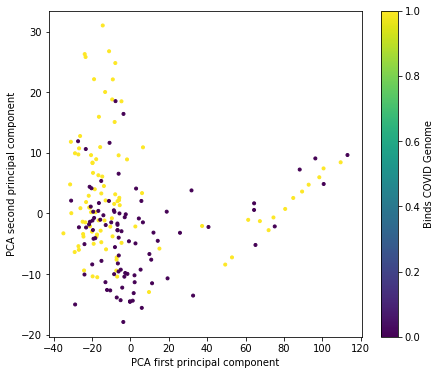

In [28]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Binds COVID Genome')

## Training Time with AutoML!

Okay... It looks like we need a Pandas data frame for the Tabular predictor...

In [29]:
train_data = pd.DataFrame(Xs_train_pca, columns=["pc{}".format(i) for i in range(1,61)])
train_data["binds_covid"] = ys_train
train_data

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60,binds_covid
0,-7.155079,-7.275114,-3.544600,-3.361179,1.304091,0.085233,-6.952634,10.021271,-2.404606,0.469289,-5.434114,0.647924,1.937873,1.758545,3.921264,0.970111,8.638610,0.968021,1.325272,-0.554689,1.391437,2.871066,1.156263,10.794481,0.423120,-5.688017,-2.593752,-4.149209,-0.238049,2.530229,5.627793,6.254470,2.816714,4.979161,-0.664411,3.981641,-1.558397,1.067116,0.226819,-0.786647,1.701567,-0.413405,0.776808,1.209963,0.485521,2.617937,1.359255,-0.794088,3.592358,-2.059277,-0.785731,-0.744421,-0.421312,-1.809620,-0.293098,-1.535943,0.315489,-0.502253,-1.111375,-1.832161,True
1,74.493965,-0.666803,3.292998,-8.890506,-6.030799,-5.571516,4.084023,-1.700836,-0.732434,0.701820,1.125923,-0.369148,-1.152504,1.930934,-0.463356,-0.715640,1.300060,1.758772,1.041155,1.005899,1.644534,-2.396135,0.550385,-0.256674,2.927363,-0.163568,-1.706194,-0.717773,0.224608,-1.400274,-1.981873,3.244682,-1.837379,0.250444,3.263386,2.073427,-1.197330,-2.223522,0.814925,-1.159127,2.966901,-1.085222,-1.238281,-0.726238,-1.505742,-0.361355,-2.246005,1.216817,-4.044116,-2.768176,-2.493476,-1.210791,0.984042,-2.031225,0.404649,1.403288,-0.393646,0.315034,3.700243,-2.189512,True
2,109.478928,8.434291,0.151093,23.771460,9.641046,1.995472,-9.193687,2.139267,1.601881,-2.442223,-1.745307,-0.327606,0.212850,-0.521772,3.356653,-0.533631,0.806619,-1.023418,1.221290,0.279416,0.364865,-0.147896,0.014741,0.351693,0.570016,0.836838,-0.233473,2.000159,-1.297451,-0.719768,0.017347,-0.570828,1.548506,-0.865406,-1.469717,-2.136107,-1.187657,-1.751210,0.720841,1.558054,0.288254,-0.213909,1.830804,-0.413817,-1.986301,-1.054505,0.843169,0.557861,0.555594,0.923212,0.804137,0.645703,1.381421,1.087832,1.699556,0.054958,-0.611822,2.252801,-1.957052,-1.211696,True
3,-4.634615,18.503439,-5.974078,-3.600371,1.677903,-0.119863,1.646903,0.579493,3.022979,1.200409,4.253499,-1.147899,-3.845051,-2.680633,0.258517,2.988750,-2.555741,-0.319801,-1.517076,-0.588585,-0.160237,0.468089,-1.695122,0.659441,0.088351,-0.552635,-0.560582,-0.655232,-0.679493,1.270612,-1.388584,0.519626,0.307480,0.292977,0.923834,1.330632,0.348264,0.135012,0.242587,0.317418,0.384054,-1.911107,0.284007,2.192369,-0.375547,1.554032,0.268838,-0.355486,-1.529834,-1.870886,1.172790,-1.040711,-0.284616,-0.454934,-1.250272,-0.506010,-2.027127,0.228091,-1.087696,0.934456,True
4,71.971260,-2.765512,3.142579,-10.225750,-3.470709,-5.499462,1.602132,-2.118712,-1.312021,1.422013,0.309934,0.653617,1.228390,1.269128,-0.709714,2.437874,-0.587288,0.880146,0.777993,0.050262,-1.386831,-1.125632,-2.038414,-0.157691,-1.542575,0.889022,-0.520876,0.250361,0.962436,0.680635,0.355333,0.376673,1.937524,-0.383964,1.113722,0.434540,0.592703,-0.245699,1.217181,-1.546525,-0.893305,-0.338977,-0.534956,1.066464,-0.785391,-0.632566,0.646598,0.252397,-0.085176,0.911617,-0.926048,0.857392,-1.691568,1.956628,0.497499,-1.552544,-1.811421,1.714308,-0.805979,0.163736,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,-8.310070,0.256470,-6.697799,-3.232172,1.475620,-1.817105,0.391347,3.272603,-1.162264,2.419388,0.415680,-2.506584,2.435050,-0.751936,-0.913039,1.978140,-2.430666,-0.364574,0.356618,1.118196,-1.331637,-1.095267,-0.921020,-0.795109,-1.357670,1.288529,1.352028,-0.907941,0.446005,-0.529530,-1.707628,-0.582210,0.385820,-0.388274,-0.244310,1.124975,-1.153495,1.903370,0.394940,-0.920780,-0.092770,-0.098372,0.820025,0.163838,0.068003,0.958545,0.463224,-0.030853,0.682804,1.451329,-0.078622,-1.122768,0.750495,-0.509315,0.315704,-0.237815,1.208190,-0.590887,-0.1

In [ ]:
# path arg says which dir to store models in
#predictor = TabularPredictor(label="binds_covid", path=(FASTA_DATA / "autogluon_models")).fit( 
#    train_data=train_data,
#    presets="good_quality_faster_inference_only_refit",
#)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "/content/drive/MyDrive/ecbm-e4060-covid-interactions/DATA/ML_Extension/autogluon_models/"
AutoGluon Version:  0.3.1
Train Data Rows:    187
Train Data Columns: 60
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [True, False]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11521.95 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2   0.796791       0.806756  22.441048                0.000846           0.376194            2      False         12
1              LightGBMXT_BAG_L1   0.770053       0.015012   1.509302                0.015012           1.509302            1      False          1
2                CatBoost_BAG_L1   0.764706       0.021546  10.010002                0.021546          10.010002            1      False          5
3         NeuralNetFastAI_BAG_L1   0.759358       0.220171   7.665339                0.220171           7.665339            1      False          8
4                 XGBoost_BAG_L1   0.754011       0.023152   1.633771                0.023152           1.633771            1      False          9
5                LightGBM_BAG_L1   0.748663       

{'leaderboard':                            model  score_val  ...  can_infer  fit_order
 0            WeightedEnsemble_L2   0.796791  ...      False         12
 1              LightGBMXT_BAG_L1   0.770053  ...      False          1
 2                CatBoost_BAG_L1   0.764706  ...      False          5
 3         NeuralNetFastAI_BAG_L1   0.759358  ...      False          8
 4                 XGBoost_BAG_L1   0.754011  ...      False          9
 5                LightGBM_BAG_L1   0.748663  ...      False          2
 6          NeuralNetMXNet_BAG_L1   0.748663  ...      False         10
 7           LightGBMLarge_BAG_L1   0.737968  ...      False         11
 8        RandomForestEntr_BAG_L1   0.705882  ...      False          4
 9          ExtraTreesEntr_BAG_L1   0.705882  ...      False          7
 10  RandomForestEntr_BAG_L1_FULL   0.705882  ...       True         16
 11    ExtraTreesEntr_BAG_L1_FULL   0.705882  ...       True         19
 12    ExtraTreesGini_BAG_L1_FULL   0.689840  ...

## Testing Time

In [ ]:
Xs_test_pca = pca.transform(Xs_test)
test_data = pd.DataFrame(Xs_test_pca, columns=["pc{}".format(i) for i in range(1,61)])
test_data

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,-10.207367,-15.867944,10.188698,-5.783739,6.996491,-1.029134,1.975172,0.421070,-0.718431,-0.001830,2.772584,-3.830617,1.544252,-2.280609,2.528839,1.629695,1.351761,-0.367839,0.204164,0.769175,0.962358,0.642312,-0.936098,-0.137428,-0.929519,0.147661,-0.389040,0.265691,0.489864,-1.396239,-1.118311,1.198708,-0.036598,0.432255,-0.606220,-1.633112,-0.880598,1.709747,0.416377,-0.893252,-0.382758,-2.381267,0.961276,-1.347623,-0.755678,0.299273,0.231435,-0.563624,-0.240974,-0.390261,0.536215,-0.061380,-1.687757,-0.617080,0.171905,-0.480016,-0.304867,-1.630682,0.054019,1.497374
1,-14.383507,1.138823,16.496513,-4.014837,11.266633,0.822277,4.254652,3.769737,2.048465,-1.679038,2.687014,5.033141,4.508251,-1.584803,-1.065386,-1.151066,1.847958,0.888342,0.524654,-0.421840,1.519845,-2.711080,-0.763246,1.083070,0.064331,0.811916,1.420616,-0.308625,1.183778,-0.147079,-0.708972,-0.119439,0.576709,-0.311166,-0.787553,0.231372,-1.814663,-2.265509,1.195684,1.620178,-1.304689,-0.665291,-0.677650,-0.984407,1.533547,2.327990,-0.945272,-1.146948,-1.121989,-1.094872,-0.565505,-0.314829,-0.663019,-2.043989,-0.360234,0.208394,0.431046,-0.931203,-0.818896,0.036584
2,-9.888495,-6.708749,-3.087256,-2.851400,1.002654,-0.014349,-6.557888,9.797709,-2.739337,0.519681,-5.375680,0.535832,1.766193,1.497075,4.247762,1.601403,8.879831,0.850185,0.906013,-0.241602,1.340784,2.539914,1.233973,10.940574,0.381353,-5.536998,-2.598888,-4.517776,-0.301485,2.602190,5.640862,6.523172,2.964818,5.149008,-0.454862,4.268188,-1.328159,0.976563,0.048782,-1.072540,1.813342,-0.782117,0.343114,1.412315,1.161169,1.926007,1.053684,1.123358,-3.631909,-1.743681,-1.455228,-1.205954,-0.005944,1.020843,1.146301,-1.108640,0.283251,0.009074,0.211129,0.410982
3,6.022157,26.730286,5.426454,-9.516687,-2.212678,10.462032,-7.968542,-3.376310,3.925040,0.153059,2.530698,0.428739,-2.930341,-3.414298,2.815231,-1.534145,-0.301415,1.450549,2.815010,0.009031,-2.792951,-3.731351,1.378777,0.979778,-3.235562,0.085556,-1.461587,0.593148,-5.077102,0.806002,-0.348056,-3.423299,-4.654805,0.393912,5.993042,-3.358039,-1.838212,6.309415,4.474522,-2.346185,5.041782,3.427147,3.561102,5.376402,0.029563,-0.489408,-0.588500,-0.265087,-1.746288,-0.762777,-1.843845,2.797687,3.405808,-1.248913,0.023590,1.863402,-2.019711,-0.094628,0.105625,-0.369018
4,8.479215,-14.093275,1.277199,-5.389850,-5.304557,-3.839885,-6.205036,-1.175157,0.353357,-1.628014,-0.196515,0.639916,1.253248,-0.577437,0.906375,3.643231,0.132518,-0.195837,2.146793,2.546758,0.459533,1.215399,-1.252825,-1.473139,-0.942471,-1.081801,-0.210566,-0.378959,-1.076359,-0.458090,-0.474703,0.236319,0.294544,0.815772,-0.321830,-0.833749,-0.170938,0.043740,0.487842,-0.180550,-1.502429,-2.138987,-1.222543,-0.647321,-1.294320,-0.547886,1.058311,-2.119839,-3.350728,-1.326342,-0.974107,0.033986,0.168562,0.433897,-0.883595,0.971594,1.970909,-0.729891,1.499097,0.012353
5,112.680908,10.216195,6.019342,14.010412,2.911211,-4.466495,-2.674174,0.176343,0.590759,-2.206399,-0.240233,1.596000,-3.181346,2.968760,-1.098909,0.945784,0.644878,-1.238280,-0.733335,0.364525,-0.127834,-0.483606,1.056743,-1.313637,1.296683,0.467689,-0.471973,-0.374303,2.130165,0.859444,2.507749,-0.417744,0.815352,-1.565346,0.853516,-1.450777,0.196269,0.138051,0.724789,-0.544486,0.673183,-0.525690,-0.936728,0.790609,1.465430,-0.079262,-0.598352,-0.761673,-0.576072,-1.168529,-1.259783,-1.897122,-0.658889,-1.175868,1.494534,-0.129553,-0.911272,-0.038048,-0.579848,0.056491
6,-8.350851,7.770735,-11.479559,-7.290299,6.086195,-3.232131,-3.364435,7.495668,-0.025837,-3.374707,1.239987,-0.056169,-2.152264,1.334027,-0.538433,-0.051555,-0.311603,1.983659,1.678777,0.187968,1.699242,1.053786,-1.059731,0.602911,-3.043326,-1.039123,-0.608

In [ ]:
y_pred_score = predictor.predict_proba(test_data)
y_pred = predictor.predict(test_data)

In [ ]:
performance_scores(ys_test, y_pred_score, y_pred)

{'accuracy': 0.782608695652174,
 'auroc': 0.8582230623818525,
 'balanced_accuracy': 0.7826086956521738,
 'f1': 0.7788461538461537}

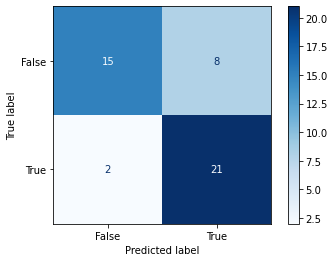

In [ ]:
cm = confusion_matrix(ys_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues")